# Streetscapes at Scale Notebook 1B: Capturing Streetscapes with Mapillary

In the other notebooks of this tutorial we have explained how to use the Static Street View API provided by the Google Maps Platform to obtain streetscape imagery. Static Street View API is one of the most widely used services due to its coverage and relatively low cost.

However, the platform has other features that may be less desirable for research. For instance, Google’s Terms of Service prohibit the distribution of Static Street View images in publications or the manipulation of images. For large numbers of images, cost may be an issue: SV imagery is inexpensive, but not free. Mapillary is one alternative platform which imposes fewer legal restrictions on streetscape images and is completely free to use, although images are of variable quality and limited geographic scope.

Here, explain how to translate the SV sampling process to the Mapillary API to download streetscape images.

## 1 Setting Up

Setting up the workflow to use Mapillary for obtaining street view images is similar to the process for Google Maps. You need to import the necessary modules, configure the working directory, and provide the API key required to access Mapillary’s services.

### 1.1 Importing Modules

In [ ]:
from google.colab import drive 
from google.colab import userdata 
import os 
import pandas as pd 
import requests  
import urllib.parse  
from PIL import Image 
import matplotlib.pyplot as plt 

### 1.2 Setting Up Directory on Google Drive

In [ ]:
# Start working on Google Colab
drive.mount('/content/drive')

In [ ]:
# TODO: Edit to your folder path
# If using a shared drive, replace 'MyDrive' with 'Shareddrives'
os.chdir('/content/drive/MyDrive/Your_Folder/1B.MapillaryStreetscapeCapture')
os.getcwd()

### 1.3 Mapillary API Key
The Mapillary API requires an access token, similar to the Google Maps [API key](https://developers.google.com/maps/get-started). This token acts as your authentication for accessing Mapillary’s services.

To obtain a Mapillary access token, follow these steps:

1. Visit the [Mapillary Developer Portal](https://www.mapillary.com/developer) and click the **"Get an access token"** button.
2. Create an account or log in if you already have one. You will be redirected to the **Developers** page.
3. Click the **"Register application"** button and complete the required fields. For the **Redirect URL**, you can use a placeholder such as `https://example.com`. Once you're done, click **Register**.
4. After registering, you will see a new entry on the page. Click the **"View"** button for the application to access its **Client Token**.
5. Copy the **Client Token**. This will be your access key for using Mapillary’s API.

Once these steps are completed, you can start making API requests to Mapillary.

In [ ]:
# TODO: Replace it with your own client token
client_token = 'MLY|8515763298471114|65526c4b6f519188675a619266f2be4b'

## 2 Locating Streetscape Images with the Mapillary API

### 2.1 Structure of Mapillary API Request
Mapillary images are accessed using an URL address. You may recall setting a `BASE_URL` when using the Static Street View API in the first notebook of this tutorial. Similarly, you can define a `BASE_URL` for making API requests to Mapillary. In the code snippet below, the `BASE_URL` is defined to specify the endpoint for accessing Mapillary's image data. We can then add our request details to this URL.

In [ ]:
# Define the base URL for the Mapillary API
BASE_URL = 'https://graph.mapillary.com/images?'

To interact with the Mapillary API and access streetscapes, you need to set two additional parameters besides the `access_token`. One is `bbox`, which defines the area to search for images, and the other is `fields`, which allows you to specify the type of metadata to include in the API response.

The `fields` parameter determines what data the API should return for each image. If you want to keep it simple and only retrieve images without additional data, you can set the `fields` parameter to specify the desired image resolution. For example, you can use `thumb_2048_url`, `thumb_1024_url`, or `thumb_256_url`, where the numbers represent the pixel width of the image and correspond to its quality. Additionally, depending on the purpose of your research, additional fields such as `id`, `capture_time`, `camera_details`, or `location_data` can be included in the request.

In [ ]:
# Size of the street view image
thumb_value = 'thumb_2048_url'

Note that Mapillary, by default, returns up to 2,000 entries in response to an API call, even though the `limit` parameter is optional. To replicate the result using the Static Street View API, where one image is obtained per coordinate, you can set `limit` to `1`.

In [ ]:
limit_value = 1

### 2.2 Finding Images Within a Bounding Box

Mapillary does not support a direct function to retrieve the closest image to a given coordinate. Instead, you need to define a box around the coordinate and search for images within it.

To address this, we will use the `bbox` parameter, which functions similarly to the `radius` parameter in the Static Street View API. The bounding box (`bbox`) is a rectangular area defined by the coordinates of its corners. This parameter specifies the geographic region where the API will search for images. By adjusting the `bbox_size` value, you can control the size of the search area.

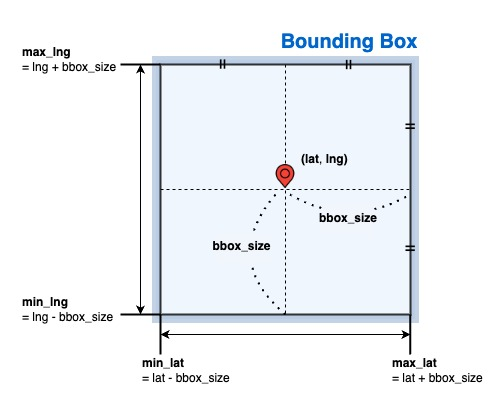

One significant limitation of Mapillary is that it has fewer streetscape images compared to Google Maps Platform. As a result, there may not be any images within a bounding box. For instance, when setting the `bbox_size` based on the coordinates of Michigan Stadium, setting the size too small may result in no available images. Therefore, you must carefully determine how large to make the `bbox_size` to balance the chances of finding images with the precision of the area.

Let’s say you want to sample images centered around a specific coordinate, just as you did previously using the Static Street View API. By setting the coordinate values and specifying the size of the bounding box, we can calculate the values for `max_lng`, `min_lng`, `max_lat`, and `min_lat` as shown below.

When `bbox_size = 0.005`, it represents a difference of 0.005 **degrees** in latitude and longitude. Since the Earth is not a perfect sphere, the distance represented by 1 degree varies by location. Based on the coordinates of the Michigan Stadium, a difference of 0.005 degrees corresponds to approximately **555 meters** in latitude and **411 meters** in longitude.

In [ ]:
lat = 42.2643255
lng = -83.7487586
bbox_size = 0.005

min_lng = lng - bbox_size
min_lat = lat - bbox_size
max_lng = lng + bbox_size
max_lat = lat + bbox_size

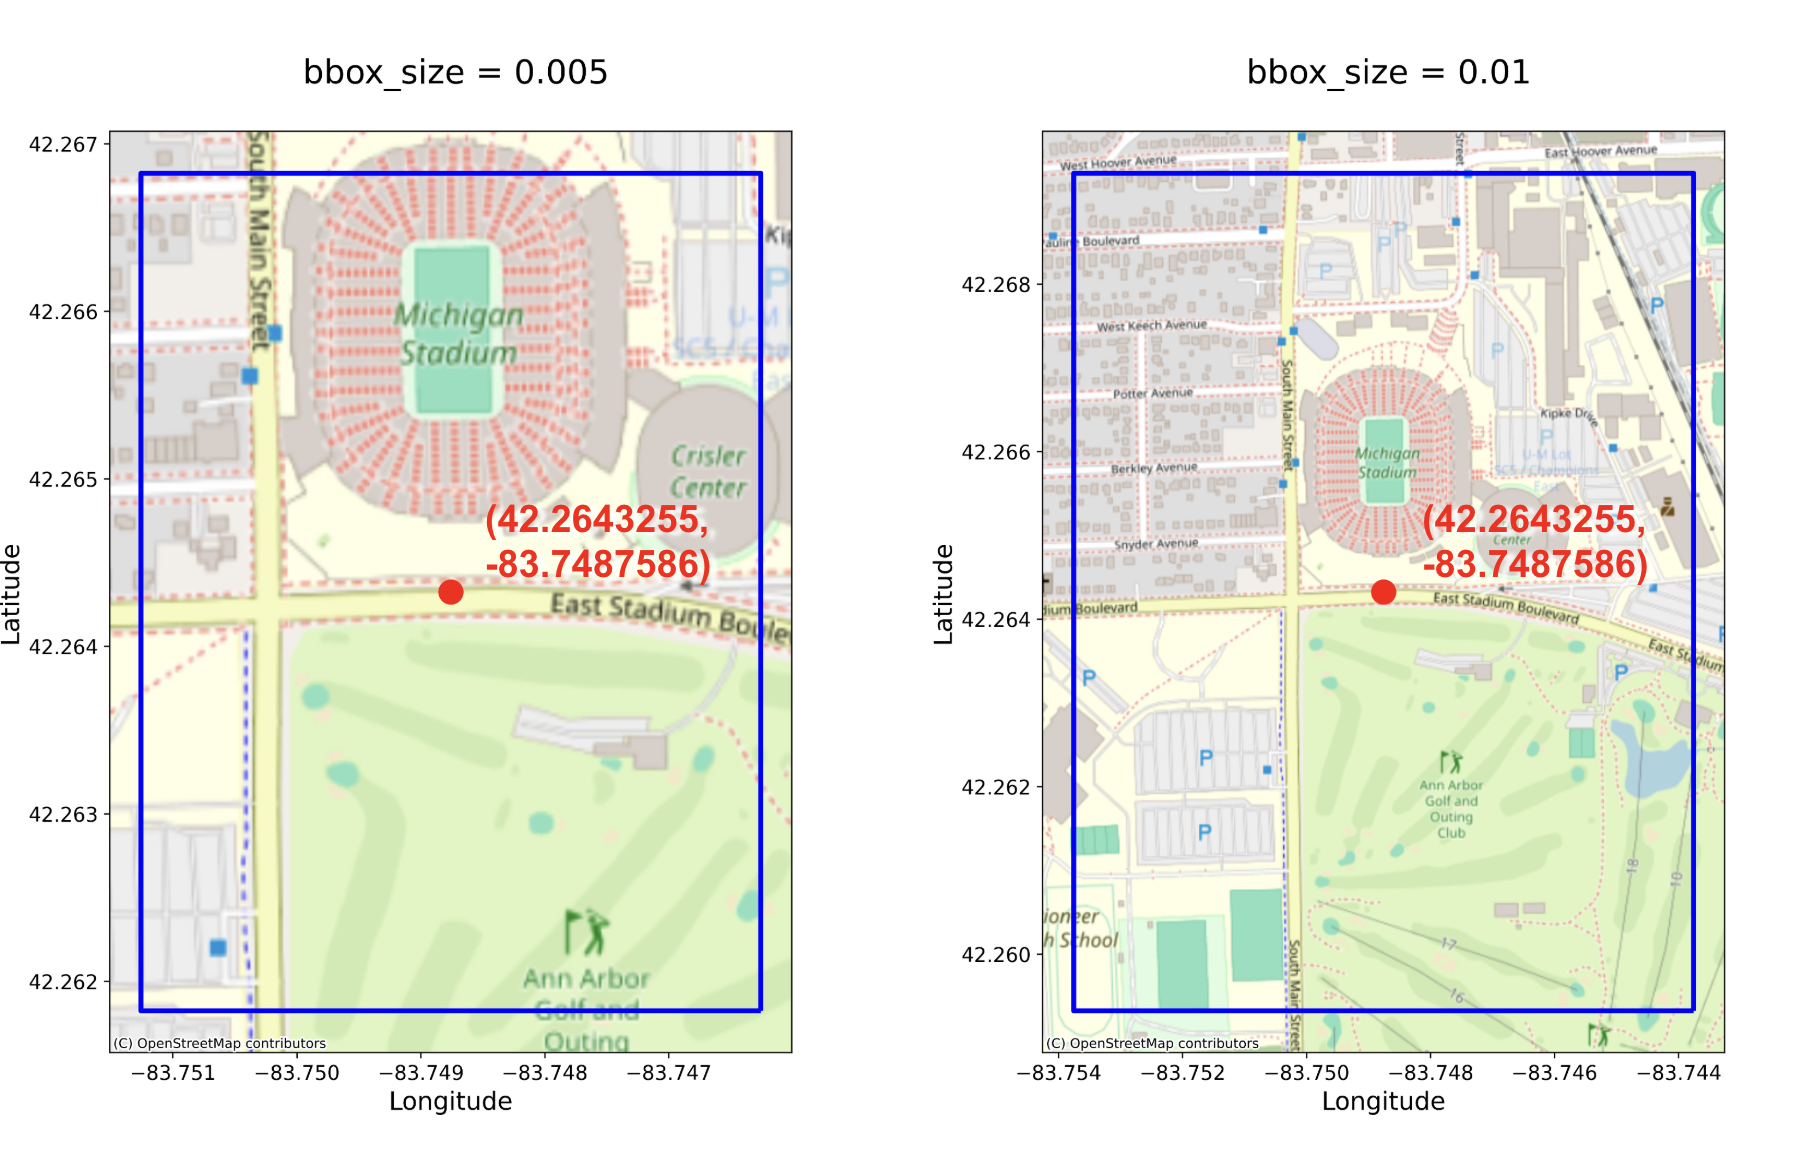

## 3 Pulling Mapillary Images Programmatically

### 3.1 Identifying an Image URL from a Mapillary API Request

Now that we have set all the necessary parameters for the API call, let's construct an
 API call URL.

In [ ]:
# Construct the URL to send to the server
mapillary_url = f"{BASE_URL}access_token={client_token}&fields={thumb_value}&limit={limit_value}&bbox={min_lng},{min_lat},{max_lng},{max_lat}&limit=1"
print(mapillary_url)

https://graph.mapillary.com/images?access_token=MLY|8515763298471114|65526c4b6f519188675a619266f2be4b&fields=thumb_2048_url&limit=1&bbox=-83.7537586,42.259325499999996,-83.7437586,42.2693255&limit=1


When you click this URL, you see the data for all Mapillary points matching your query parameters (we have used the `limit` parameter to return a single point).

One of the fields, `"thumb_2048_url"`, contains the URL of the streetscape image. You can click this link to access the image manually manually get the image by clicking the link next to `"thumb_2048_url"`. We can also write a function to do this programmatically.

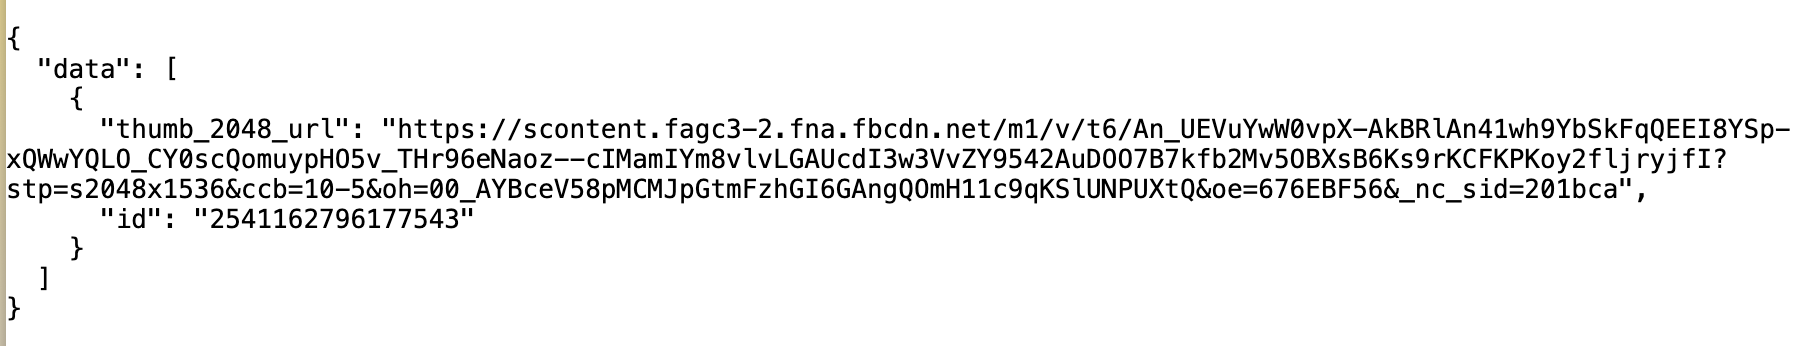

### 3.2 Defining a Function to Pull a Single Image

The following code demonstrates how to retrieve and display the image using the URL provided in the JSON response.

For each image, the code:
1. Extracts the image URL from the `"thumb_2048_url"` field in the JSON data.
2. Retrieves the image using the URL.
3. Opens and displays the image using `Pillow` and `Matplotlib`.

This allows you to quickly visualize the images from an API call.

In [ ]:
def mapillary_pull_image(lat, lng, bbox_size=0.005):
    min_lng = lng - bbox_size
    min_lat = lat - bbox_size
    max_lng = lng + bbox_size
    max_lat = lat + bbox_size

    BASE_URL = 'https://graph.mapillary.com/images?'
    mapillary_url = f'{BASE_URL}access_token={client_token}&fields=thumb_2048_url&bbox={min_lng},{min_lat},{max_lng},{max_lat}&limit=1'

    response = requests.get(mapillary_url)
    data = response.json()

    if 'data' in data and len(data['data']) > 0:
        image_url = data['data'][0]['thumb_2048_url']
        img_response = requests.get(image_url, stream=True)
        image = Image.open(img_response.raw)

        return image

    else:
        print("No image available for the coordinate.")
        return None

As we request to get a street view image around the coordinate, it will display an image this time. Apparently, the image is quite different from the one we obtained ealier with Static Street View API as Mapillary's street view images are collected in different method to Static Street View API.

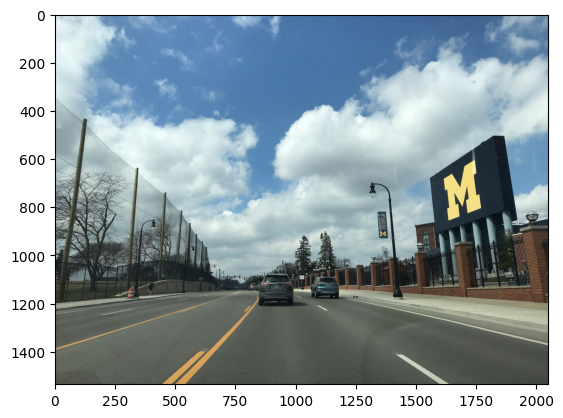

In [ ]:
lat = 42.2643255
lng = -83.7487586
bbox_size = 0.005

image = mapillary_pull_image(lat, lng, bbox_size)
plt.imshow(image)
plt.show()

### 3.3 Exporting Mapillary Image Metadata



Mapillary retrieves images based on a bounding box, which means the actual location where the image was taken might differ from the coordinates you provide. Additionally, you may want to examine other details about the image, such as who uploaded it or when it was captured. To obtain such detailed information along with the image, you can save the metadata of the image.

The code below presents a modified function that includes metadata extraction, returning both the image and its associated metadata in a structured format. The metadata will be stored in a DataFrame object as `metadata_df`.

In [ ]:
def mapillary_pull_image_metadata(lat, lng, bbox_size=0.005, fields=None):
    if fields is None:
        fields = ('id,thumb_2048_url')

    min_lng = lng - bbox_size
    min_lat = lat - bbox_size
    max_lng = lng + bbox_size
    max_lat = lat + bbox_size

    mapillary_url = f'{BASE_URL}access_token={client_token}&fields={fields}&bbox={min_lng},{min_lat},{max_lng},{max_lat}&limit=1'

    response = requests.get(mapillary_url)
    data = response.json()

    if 'data' in data and len(data['data']) > 0:
        # Extract the image's data
        image_data = data['data'][0]
        image_url = image_data.get('thumb_2048_url', None)

        if image_url:
            img_response = requests.get(image_url, stream=True)
            image = Image.open(img_response.raw)
        else:
            image = None

        # Convert metadata to a DataFrame
        metadata_df = pd.DataFrame([image_data])

        return image, metadata_df

    else:
        print("No image available for the coordinate.")
        return None, None


In the current `mapillary_pull_image_metadata` function, if you do not specify the `fields` parameter, it is set to default, fetching only the image's `id` and `url`. If you want to retrieve additional information, you can manually select the desired fields as shown below.

The field names listed below are accurate as of August 2024 but may be subject to additions, deletions, or changes over time. For more information about the available fields, refer to the "Fields" section under the "Images" category of the [official Mapillary documentation](https://www.mapillary.com/developer/api-documentation#image).  






In [ ]:
fields = ('id,thumb_2048_url,detections,altitude,atomic_scale,camera_parameters,camera_type,captured_at,compass_angle,'
          'computed_altitude,computed_compass_angle,computed_geometry,computed_rotation,creator,exif_orientation,geometry,'
          'height,is_pano,make,model,thumb_256_url,thumb_1024_url,thumb_original_url,merge_cc,mesh,sequence,sfm_cluster,width'
         )

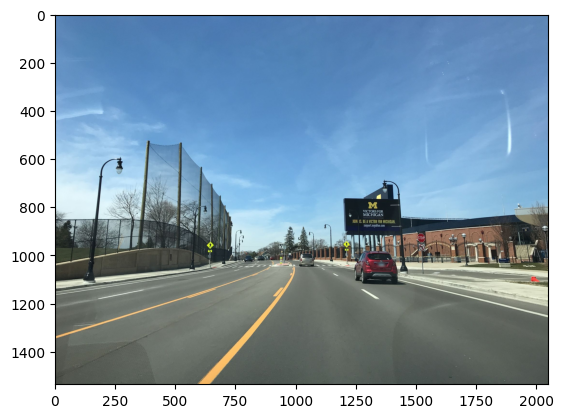

In [ ]:
lat = 42.2643255
lng = -83.7487586
bbox_size = 0.005

image, metadata_df = mapillary_pull_image_metadata(lat, lng, bbox_size, fields)
plt.imshow(image)
plt.show()



To check the saved metadata, you can run the code below.

In [ ]:
display(metadata_df)

id                                     thumb_2048_url  \
0  4011591765597716  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   

                                          detections   altitude  atomic_scale  \
0  {'data': [{'id': '4037203163036576'}, {'id': '...  263.98666      0.981699   

                                   camera_parameters  camera_type  \
0  [1.0518170830899, 0.036045197053648, -0.058136...  perspective   

     captured_at  compass_angle  computed_altitude  ...   make   model  \
0  1524429258129     282.252502         265.622572  ...  Apple  iPhone   

                                       thumb_256_url  \
0  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   

                                      thumb_1024_url  \
0  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   

                                  thumb_original_url      merge_cc  \
0  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...  2.620474e+18   

                                                mesh                sequence  \
0  {'id': '819363762336644', 'url': 'https://scon...  uxa52LwxciIQS9fOfqQ8ZA   

                                         sfm_cluster width  
0  {'id': '213198420253243', 'url': 'https://scon...  4032  

[1 rows x 28 columns]

### 3.4 Pulling Multiple Images and Metadata from Mapillary

Now, as in the first notebook, we will scale up our functions to sample images from a list of coordinates.

Here, we'll use a list of locations in Ann Arbor stored in a CSV file.

In [ ]:
# Read CSV file and generate list of locations
df = pd.read_csv('/content/drive/MyDrive/Your_Folder/1A.StreetViewStreetscapeCapture/AA_coordinates.csv')
locations = df[['lat', 'lng', 'place']].to_dict('records')
display(locations)

[{'lat': 42.2643255, 'lng': -83.7487586, 'place': 'Michigan Stadium'},
 {'lat': 42.2766767, 'lng': -83.7357508, 'place': 'Weiser Hall'},
 {'lat': 42.2781038, 'lng': -83.7461877, 'place': 'AA District Library'},
 {'lat': 42.2795045, 'lng': -83.7417636, 'place': 'Michigan Theater'},
 {'lat': 42.2451094, 'lng': -83.6995369, 'place': "DJ's Bakery"}]

Similarly to how we defined the `multiple_pull_images` function using the `pull_images` function in our Google SV notebook, we can define a `multiple_mapillary_pull_images` function using the `mapillary_pull_images` function we defined in 3.2.

This time, if the `bbox_size` is not explicitly provided, the `mapillary_pull_image` function will use its own default value (0.005) for `bbox_size`, since this parameter is passed directly to `mapillary_pull_images`. In the same way, if the `fields` parameter is not explicitly provided, the `mapillary_pull_image` function will default to fetching only the `id` and `url` of the image.

In [ ]:
def multiple_mapillary_pull_image_metadata(locations, bbox_size=None, fields=None):
    images = []
    for loc in locations:
        lat, lng = loc['lat'], loc['lng']
        image = multiple_mapillary_pull_image_metadata(lat, lng, bbox_size, fields)
        images.append(image)

    return images

Likewise, we can scale up our function `mapillary_pull_image_metadata` to pull metadata from a list of points.

In [ ]:
def multiple_mapillary_pull_image_metadata(locations, bbox_size, fields):
    images = []
    metadata_list = []

    for loc in locations:
        lat, lng, place = loc['lat'], loc['lng'], loc['place']
        image, metadata_df = mapillary_pull_image_metadata(lat, lng, bbox_size, fields)
        images.append(image)

        # Add original coordinates and place name to metadata
        if metadata_df is not None:
            metadata_df['place'] = place
            metadata_df['original_lat'] = lat
            metadata_df['original_lng'] = lng

            # Reorder columns to move original_lat, original_lng, and place to the front
            cols = ['place', 'original_lat', 'original_lng'] + [col for col in metadata_df.columns if col not in ['place', 'original_lat', 'original_lng']]
            metadata_df = metadata_df[cols]

        metadata_list.append(metadata_df)

    if metadata_list:
        combined_metadata_df = pd.concat(metadata_list, ignore_index=True)
    else:
        combined_metadata_df = pd.DataFrame()

    return images, combined_metadata_df


Let's apply this function to the coordinates in our CSV file. In this example, we reduced the `bbox_size` to 0.0005 for each location to find images closer to the coordinate values.

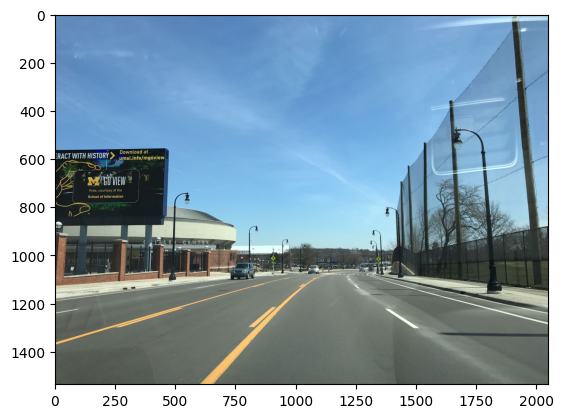

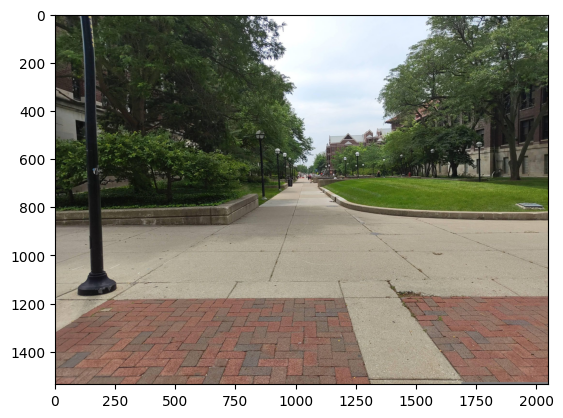

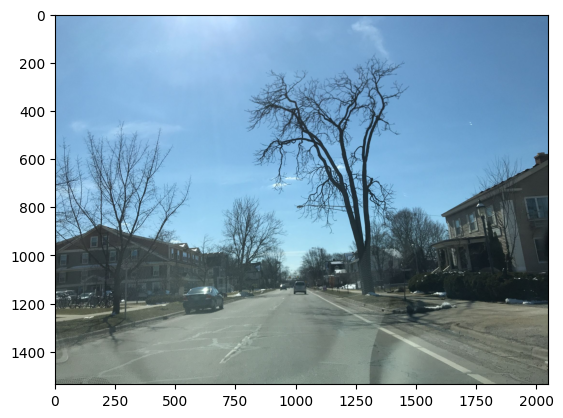

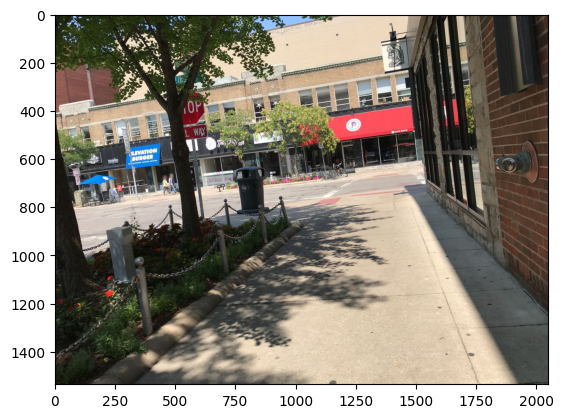

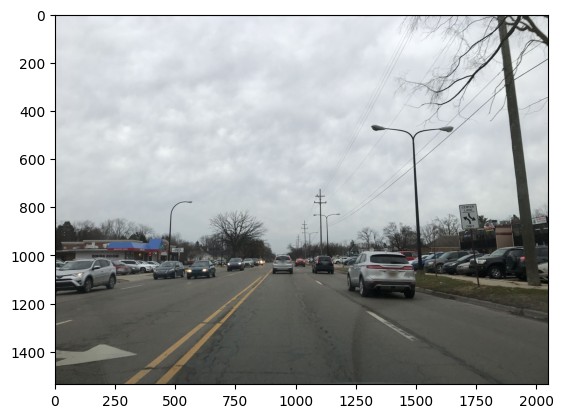

In [ ]:
pulled_images, combined_metadata_df = multiple_mapillary_pull_image_metadata(locations, bbox_size=0.0005, fields=fields)
for image in pulled_images:
    plt.imshow(image)
    plt.show()

In [ ]:
display(combined_metadata_df)

place  original_lat  original_lng                id  \
0     Michigan Stadium     42.264325    -83.748759   750488575642161   
1          Weiser Hall     42.276677    -83.735751  1211602290023724   
2  AA District Library     42.278104    -83.746188  1707826312737394   
3     Michigan Theater     42.279505    -83.741764  3895194020574724   
4          DJ's Bakery     42.245109    -83.699537   368914224549966   

                                      thumb_2048_url  \
0  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
1  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
2  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
3  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
4  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   

                                          detections    altitude  \
0              {'data': [{'id': '754865111871174'}]}  268.354040   
1  {'data': [{'id': '1211663950017558'}, {'id': '...    0.000000   
2                                                NaN  264.310276   
3  {'data': [{'id': '3925885987505527'}, {'id': '...  272.873257   
4  {'data': [{'id': '372668764174512'}, {'id': '3...  251.078282   

   atomic_scale                                  camera_parameters  \
0      0.983386  [0.79840165716813, 0.042646204289771, -0.06257...   
1      1.035499  [0.69655012544254, 0.019845375662482, -0.01153...   
2      1.064199  [0.83404401407222, 0.038434361370561, -0.05978...   
3      0.766693  [0.85036270657568, 0.045759434806562, -0.05375...   
4      1.033559  [1.1237743320953, 0.037757622355977, -0.057831...   

   camera_type  ...     make   model  \
0  perspective  ...    Apple  iPhone   
1  perspective  ...  Nothing    A065   
2  perspective  ...    Apple  iPhone   
3  perspective  ...    Apple  iPhone   
4  perspective  ...    Apple  iPhone   

                                       thumb_256_url  \
0  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
1  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
2  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
3  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
4  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   

                                      thumb_1024_url  \
0  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
1  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
2  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
3  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   
4  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...   

                                  thumb_original_url      merge_cc  \
0  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...  1.072421e+18   
1  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...  1.073509e+09   
2  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...  1.311992e+18   
3  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...  3.992985e+18   
4  https://scontent-ord5-1.xx.fbcdn.net/m1/v/t6/A...  1.502536e+18   

                                                mesh                sequence  \
0  {'id': '1139231069896096', 'url': 'https://sco...  4jLb2pU0fZToLXDuM5rBRA   
1  {'id': '1208025853555941', 'url': 'https://sco...  cpMIl6U7ejV21SvCDs39PE   
2  {'id': '868777133702123', 'url': 'https://scon...  RYiq_8y1x9js0UESN-3Mvg   
3  {'id': '3874002442689430', 'url': 'https://sco...  6y9wqh7eQ8aZ0q949f5Q9g   
4  {'id': '1876761545834465', 'url': 'https://sco...  1GQXs9YWRPWSBGBU_CBOjw   

                                         sfm_cluster  width  
0  {'id': '440526673923818', 'url': 'https://scon...   4032  
1  {'id': '1195242535159637', 'url': 'https://sco...   4096  
2                          {'id': '528141534846851'}   4032  
3                         {'id': '1935636183243676'}   4032  
4  {'id': '537720147402323', 'url': 'https://scon...   4032  

[5 rows x 31 columns]

### 3.5 Saving Images and Metadata

Now we have a list named `pulled_images` that contains all the sampled images. The `locations` list includes the corresponding `place`, `lat`, and `lng` values for each image. And we have a `combined_metadata_df` DataFrame with information about each image. We can write one more function to merge and save all this; let's call it `save_image_metadata`.

This function takes four parameters: `pulled_images`, `combined_metadata_df`, `locations`, and `export_path`. The `pulled_images` parameter is a list of images, and `locations` contains details about each image, such as `place`, `lat`, and `lng`. The `export_path` parameter specifies the directory where the images and metadata should be saved. The filenames for the images are structured using the `prefix` string along with the `place` information stored in `locations`.

The metadata is saved in a CSV file named `metadata.csv`, ensuring that all the metadata fields along with the original `place`, `lat`, and `lng` values are preserved.

In [ ]:
def save_image_metadata(pulled_images, combined_metadata_df, locations, export_path='./export/', prefix='AnnArbor'):
    os.makedirs(export_path, exist_ok=True)
    metadata_output_file = os.path.join(export_path, "metadata.csv")

    # Save images
    for idx, (image, loc) in enumerate(zip(pulled_images, locations)):
        if image is not None:
            place = loc['place'].replace(" ", "_")
            file_name = f"{prefix}_{place}.jpg"
            file_path = os.path.join(export_path, file_name)
            image.save(file_path)
            print(f"Saved image: {file_path}")

    # Save metadata as CSV
    if not combined_metadata_df.empty:
        combined_metadata_df.to_csv(metadata_output_file, index=False)
        print(f"Metadata saved as: {metadata_output_file}")
    else:
        print("No metadata to save.")


Finally, by running the code below, you can save all sampled images and their metadata.

In [ ]:
save_image_metadata(pulled_images, combined_metadata_df, locations, export_path='./export/', prefix='AnnArbor')

Saved image: ./export/AnnArbor_Michigan_Stadium.jpg
Saved image: ./export/AnnArbor_Weiser_Hall.jpg
Saved image: ./export/AnnArbor_AA_District_Library.jpg
Saved image: ./export/AnnArbor_Michigan_Theater.jpg
Saved image: ./export/AnnArbor_DJ's_Bakery.jpg
Metadata saved as: ./export/metadata.csv
